In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2

import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

## **Dataset**

#### **Load Training Data**
Now, let's load our data using pyH5 package. The training data contains images, landmarks coordinates and labels.

In [2]:
## Loading training data tables from H5py files

## 1. IMAGES
h5f = h5py.File('datasets/data_train_images.h5','r')
train_images = h5f['data_train_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('datasets/data_train_landmarks.h5','r')
train_landmarks = h5f['data_train_landmarks'][:]
h5f.close()

## 3. LABELS
h5f = h5py.File('datasets/data_train_labels.h5','r')
train_labels = h5f['data_train_labels'][:]
h5f.close()


## display the size of the different data tables
print("> Images")
print('Number of training images     :', train_images.shape[0])
print('Number of frames per sequence :', train_images.shape[1])
print('Image shape                   :', train_images[0][0].shape)

print("\n> Landmarks")
print('Number of landmarks in a face      :', train_landmarks.shape[2])
print('Number of coordinates per landmark :', train_landmarks.shape[-1])


print("\n> Labels")
print('Number of training labels:', train_labels.shape[0])

## Create an expression map to map labels (integer values) to the corresponding expression
expressions = ['Happy','Fear','Surprise','Anger','Disgust','Sad']
expression_mapping = dict(zip(range(len(expressions)), expressions))
print('\n> Expressions map:')
print(expression_mapping)

> Images
Number of training images     : 486
Number of frames per sequence : 10
Image shape                   : (200, 200)

> Landmarks
Number of landmarks in a face      : 478
Number of coordinates per landmark : 3

> Labels
Number of training labels: 486

> Expressions map:
{0: 'Happy', 1: 'Fear', 2: 'Surprise', 3: 'Anger', 4: 'Disgust', 5: 'Sad'}


#### **Load Test Data**
For the test data, we only have access to images and landmarks coordinates ! **LABELS ARE NOT AVAILABLE !**
> **Note:** You are supposed to train a model to predict the labels for the testing samples.

In [3]:
## Loading testing data tables from H5py files
## 1. IMAGES
h5f = h5py.File('datasets/data_test_images.h5','r')
test_images = h5f['data_test_images'][:]
h5f.close()

## 2. LANDMARKS
h5f = h5py.File('datasets/data_test_landmarks.h5','r')
test_landmarks = h5f['data_test_landmarks'][:]
h5f.close()

## display the size of the different data tables
print("> Images")
print('Number of testing images      :', test_images.shape[0])
print('Number of frames per sequence :', test_images.shape[1])
print('Image shape                   :', test_images[0][0].shape)

print("\n> Landmarks")
print('Number of landmarks in a face      :', test_landmarks.shape[2])
print('Number of coordinates per landmark :', test_landmarks.shape[-1])

> Images
Number of testing images      : 206
Number of frames per sequence : 10
Image shape                   : (200, 200)

> Landmarks
Number of landmarks in a face      : 478
Number of coordinates per landmark : 3


#### **Visualize Data**

In [4]:
def draw_landmarks_on_face(image, landmarks, draw_tesselation=True, draw_contours=True, draw_irises=True):
    """
    image: np.ndarray of shape (W, H) or (W, H, 3)
    landmarks: np.ndarray of shape (L=478, d=3)
    """

    ## image should be BGR
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    annotated_image = np.copy(image)

    ## Put the landmarks in a normalized list
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
              landmark_pb2.NormalizedLandmark(x=x, y=y, z=z) for (x, y, z) in landmarks
            ])

    if draw_tesselation:
        ## FACE MESH TESSELATION
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_tesselation_style())

    if draw_contours:
        ## FACE MESH CONTOURS
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp.solutions.drawing_styles
            .get_default_face_mesh_contours_style())

    if draw_irises:
        ## FAC MESH IRISES
        solutions.drawing_utils.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks_proto,
            connections=mp.solutions.face_mesh.FACEMESH_IRISES,
              landmark_drawing_spec=None,
              connection_drawing_spec=mp.solutions.drawing_styles
              .get_default_face_mesh_iris_connections_style())

    return annotated_image


def draw_image_sequence(sequence, dispaly_frames_title=False, sup_title=None):

    """
    sequence: list/numpy array of shape (N, W, H) or (N, W, H, 3)
    """

    N = len(sequence)

    plt.figure(figsize=(22, 2))
    for i, img in enumerate(sequence, start=1):
        plt.subplot(1, N, i)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        if dispaly_frames_title:
            plt.title(f'frame {i}')
    if sup_title is not None:
        plt.suptitle(sup_title)
    plt.show()

def draw_landmarks_on_face_sequence(landmarks_sequence, image_sequence=None, draw_tesselation=True, draw_contours=True, draw_irises=True, title=None):
    """
    landmarks_sequence: list/numpy array of shape (N, L=478, d=3)
    image_sequence[optional]: list/numpy array of shape (N, W, H) or (N, W, H, 3)
    """

    N = landmarks_sequence.shape[0]

    if image_sequence is not None:
        ## landmarks_sequence & image_sequence should have the same number of samples !
        assert len(image_sequence) == len(landmarks_sequence)
    else:
        image_sequence = np.zeros((N, 200, 200, 3)).astype(np.uint8)

    annotated_images = []
    for i, (img, landamrks) in enumerate(zip(image_sequence, landmarks_sequence), start=1):
        annotated_image = draw_landmarks_on_face(img,
                                                 landamrks,
                                                 draw_tesselation=draw_tesselation,
                                                 draw_contours=draw_contours,
                                                 draw_irises=draw_irises)
        annotated_images.append(annotated_image)

    draw_image_sequence(annotated_images, sup_title=title)

Sequence label: Anger


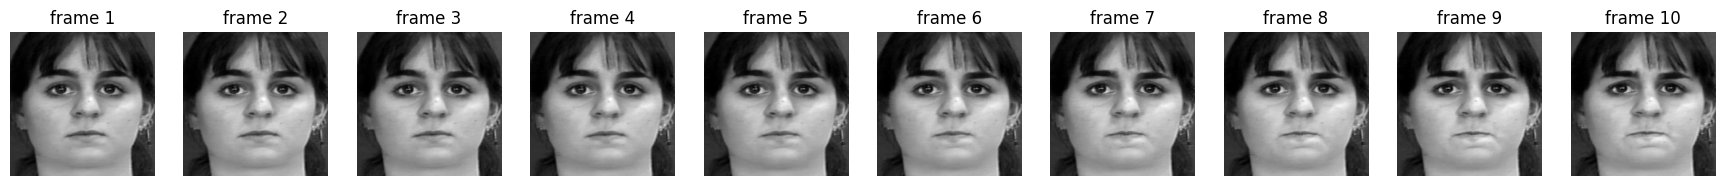

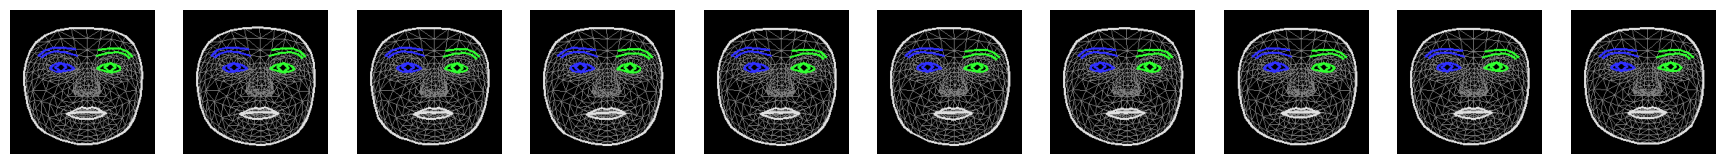

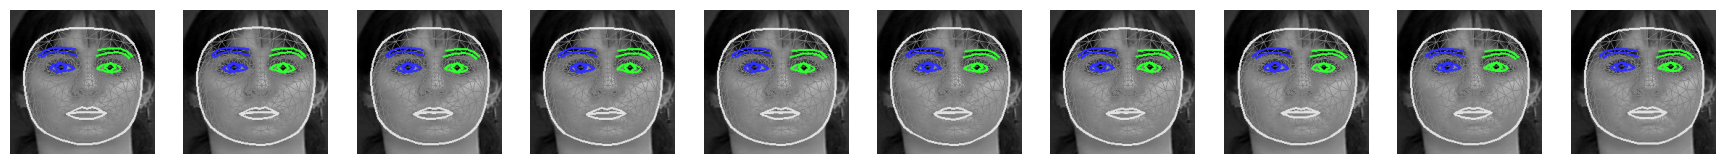

In [5]:
## display a random sequence
idx = np.random.randint(len(train_landmarks))
img_sequence = train_images[idx]
landmarks_sequence = train_landmarks[idx]
print(f'Sequence label: {expression_mapping[train_labels[idx]]}')

## display original sequence
draw_image_sequence(img_sequence, dispaly_frames_title=True)

## draw original landmarks
draw_landmarks_on_face_sequence(landmarks_sequence)

## draw images and landmarks
draw_landmarks_on_face_sequence(landmarks_sequence, img_sequence)

You can also use the following function to extract differents meshes from the face landmarks including: TESSELATION (in gray), CONTOURS (in white, blue and green) and IRISES in (green and blue).

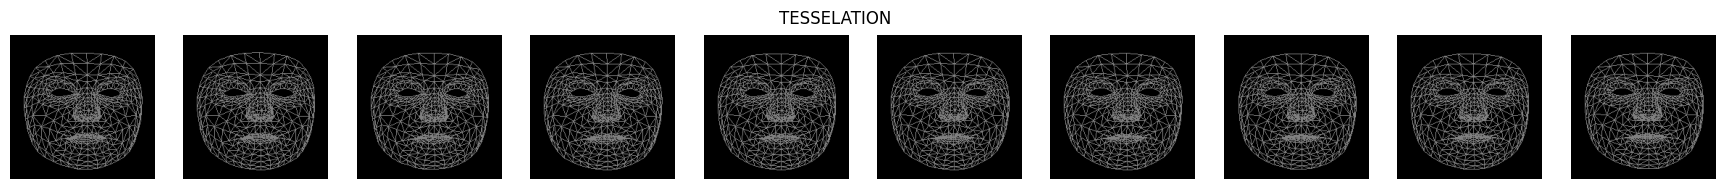

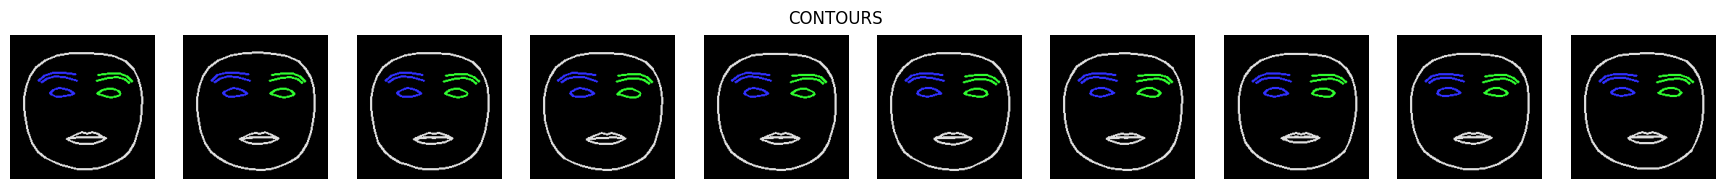

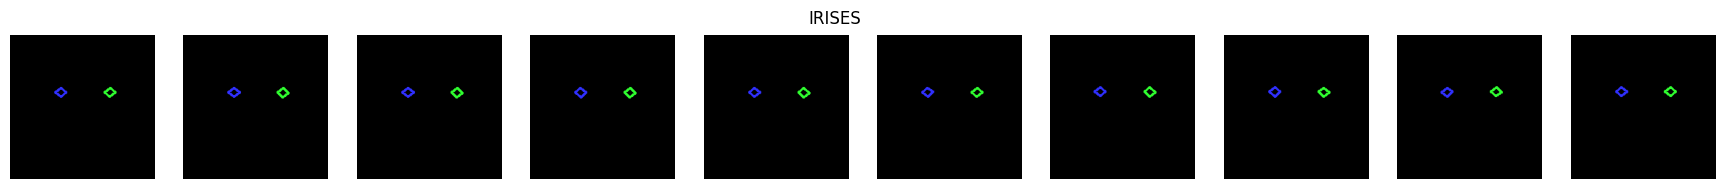

In [6]:
## draw TESSELATION ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=True, draw_contours=False, draw_irises=False, title='TESSELATION')
## draw CONTOURS ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=False, draw_contours=True, draw_irises=False, title='CONTOURS')
## draw IRISES ONLY
draw_landmarks_on_face_sequence(landmarks_sequence, draw_tesselation=False, draw_contours=False, draw_irises=True, title='IRISES')

In [7]:
def extract_tesselation_landmarks(landmarks):
    """Returns the TESSELATION LANDMARKS"""
    ## get tesselation landmarks indices
    TESSELATION_INDICES = list(mp.solutions.face_mesh.FACEMESH_TESSELATION)
    TESSELATION_INDICES = np.unique(TESSELATION_INDICES)
    ## extract landmarks
    TESSELATION_landmarks = landmarks[TESSELATION_INDICES]
    return TESSELATION_landmarks

def extract_contours_landmarks(landmarks):
    """Returns the CONTOURS LANDMARKS"""
    ## get contours landmarks indices
    CONTOURS_INDICES = list(mp.solutions.face_mesh.FACEMESH_CONTOURS)
    CONTOURS_INDICES = np.unique(CONTOURS_INDICES)
    ## extract landmarks
    contours_landmarks = landmarks[CONTOURS_INDICES]
    return contours_landmarks

def extract_irises_landmarks(landmarks):
    """Returns the IRISES LANDMARKS"""
    ## get irises landmarks indices
    IRISES_INDICES = list(mp.solutions.face_mesh.FACEMESH_IRISES)
    IRISES_INDICES = np.unique(IRISES_INDICES)
    ## extract landmarks
    irises_landmarks = landmarks[IRISES_INDICES]
    return irises_landmarks

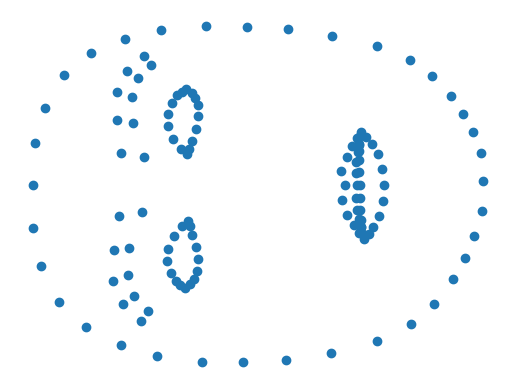

In [8]:
## an example: extracting the contours landmarks
contours_landmarks = extract_contours_landmarks(landmarks_sequence[-1])
plt.scatter(contours_landmarks[:, 1], contours_landmarks[:, 0])
plt.axis('off')
plt.show()

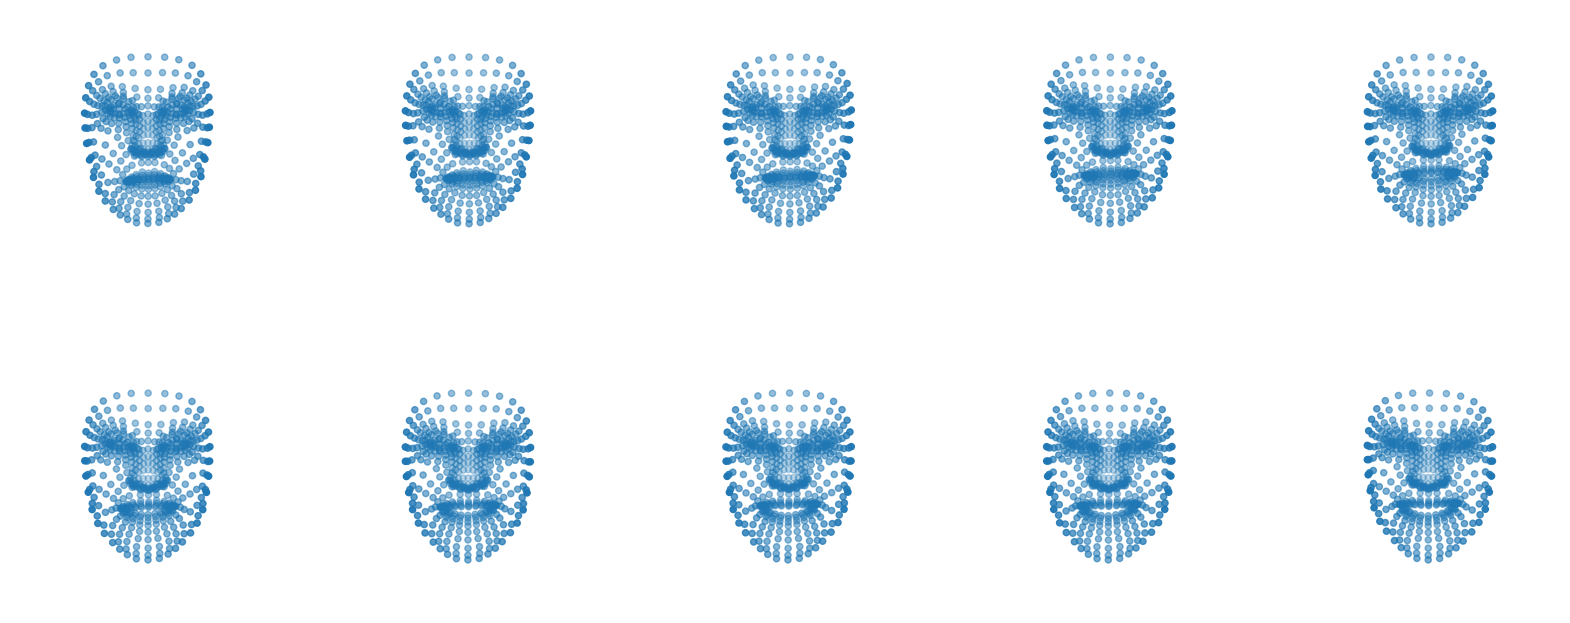

In [9]:
def plot_landmark_sequence(image_index):
    """
    Display the 3D representation of landmark for the full sequence
    """

    fig = plt.figure(figsize=(20, 8))

    # For each image of the sequence
    for i in range(len(train_landmarks[image_index])):
        # Add the subplot
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        ax.set_box_aspect((1, 1, 1.4))
        ax.axis('off')
        ax.view_init(0, 90, 0)
        # Scatter the 3 axis
        ax.scatter(train_landmarks[image_index][i][:,0], train_landmarks[image_index][i][:,2], -train_landmarks[image_index][i][:,1])

    plt.show()

# Example
plot_landmark_sequence(17)

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def build_mlp(train_features, test_features, train_targets, test_targets, num_neurons=2):
    """
    Train a Perceptron and print the accuracy of the model
    """
    classifier = MLPClassifier(hidden_layer_sizes=num_neurons, max_iter=500, activation='relu', solver='sgd', random_state=762, learning_rate='invscaling')
    classifier.fit(train_features, train_targets)

    predictions = classifier.predict(test_features)
    score = accuracy_score(test_targets, predictions)
    print(f"Perceptron accuracy: {score}")

In [47]:
def simplify_landmarks(landmarks):
    """
    Simplify a set of landmarks by extracting the contour and transforming the data
    """
    # Constants for better understanding of the code
    NUMBER_OF_SEQUENCES = 10
    NUMBER_OF_CONTOUR_POINTS = 128

    # Creates empty array with all the simplified landmarks
    simplified_landmarks = np.zeros((landmarks.shape[0], NUMBER_OF_CONTOUR_POINTS))

    for image in range(len(simplified_landmarks)):
        # Extract the contours of each sequence
        transform = np.zeros((NUMBER_OF_SEQUENCES, NUMBER_OF_CONTOUR_POINTS))
        for sequence in range(len(landmarks[image])):
            contours = extract_contours_landmarks(landmarks[image][sequence])
            transform[sequence] -= contours[:, 1]

        # transform the trajectory of each point with the (max - min) value, meaning the distance travelled
        for point in range(NUMBER_OF_CONTOUR_POINTS):
            column = transform[:, point]
            simplified_landmarks[image][point] = round((np.max(column) - np.min(column)) * 100, 5)

    return simplified_landmarks

# Simplify both train and test landmarks
train_simplified_landmarks = simplify_landmarks(train_landmarks)
test_simplified_landmarks = simplify_landmarks(test_landmarks)
print("Successfully simplified the landmarks")

Successfully simplified the landmarks


In [65]:
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange

# Split the data
X_landmarks, X_landmarks_test, Y_train, Y_test = train_test_split(train_simplified_landmarks, train_labels)


# build_mlp(X_landmarks, X_landmarks_test, Y_train, Y_test) # You can activate the perceptron but the accuracy is bad

score, iteration = 0, 0
target = 0.80
max_iteration = 10

# Train a RandomForest until it reaches the target accuracy
for iteration in trange(max_iteration):
    rf = RandomForestClassifier(criterion='gini', max_features=0.5, class_weight='balanced')
    rf.fit(X_landmarks, Y_train)
    score = accuracy_score(Y_test, rf.predict(X_landmarks_test))

    if score > target:
        print(f"Random Forest accuracy: {score}")
        break

else:
    print(f"Failed to get over {target} accuracy, stuck with: {score}")

100%|██████████| 10/10 [00:16<00:00,  1.61s/it]

Failed to get over 0.8 accuracy, stuck with: 0.7622950819672131


In [66]:
import csv
import datetime

def write_predictions(predictions):
    """
    Write the predictions in the right format in a file with name 'predictions_date_hour'
    """
    file_name = f"datasets/predictions_{datetime.datetime.now().strftime('%Y-%M-%d_%Hh%M')}.csv"

    with open(file_name, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Id", "Expression"])

        for i, predicted in enumerate(predictions):
            writer.writerow([i, predicted])

    print(f"Successfully wrote the predictions in file {file_name} with {round(score * 100)}% of accuracy on the model")

write_predictions(rf.predict(test_simplified_landmarks))

Successfully wrote the predictions in file datasets/predictions_2024-07-30_11h07.csv with 76% of accuracy on the model


In [76]:
import xgboost
from ray import train

# Training method
def train_boost_genre(config):
    # Split the data
    # X = train_simplified_landmarks
    X = train_landmarks
    y = train_labels
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=12345)

    # Creates the XGBoost model
    train_set = xgboost.DMatrix(X_train, label=y_train)
    test_set = xgboost.DMatrix(X_test, label=y_test)
    results = {}

    booster = xgboost.train(
        config['params'],
        train_set,
        evals=[(test_set, "eval")],
        evals_result=results,
        verbose_eval=False,
        early_stopping_rounds=config['early_stopping_rounds'],
        xgb_model=config['model']
    )

    # Predict the genre and display the accuracy
    y_pred = booster.predict(test_set)
    accuracy = accuracy_score(y_test, y_pred)

    train.report({"accuracy": accuracy, "done": True, "merror": results['eval']['merror'][-1],
                  "mlogloss": results['eval']['mlogloss'][-1], "model": booster})

    return booster, accuracy, results

In [77]:
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray import tune

# Tries a lot of configuration by tuning the parameters
b = None
config = {
    'params': {
        "objective": "multi:softmax",
        "eval_metric": ["merror", "mlogloss"],
        "max_depth": tune.randint(1, 200),
        "min_child_weight": tune.uniform(0, 20),
        "subsample": tune.uniform(0.2, 1.0),
        "eta": tune.loguniform(1e-7, 1e-1),
        "num_class": len(expressions),
        "tree_method": tune.choice(['auto', 'exact', 'approx', 'hist'])
    },
    "early_stopping_rounds": tune.randint(10, 10000),
    "model": b
}
scheduler = ASHAScheduler(
    max_t=50, grace_period=5, reduction_factor=2
)
tuner = tune.Tuner(
    train_boost_genre,
    tune_config=tune.TuneConfig(
        metric="merror",
        mode="min",
        num_samples=100,
        scheduler=scheduler
    ),
    param_space=config,
)

# Find the best config on the accuracy parameter
results = tuner.fit()
best_trial = results.get_best_result("accuracy", "max", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation accuracy: {best_trial.metrics['accuracy']:.4f}")
print(f"Best trial final validation error: {best_trial.metrics['merror']:.4f}")
print(f"Best trial final validation logloss: {best_trial.metrics['mlogloss']:.4f}")
print(best_trial)

ValueError: Tracked actor is not managed by this event manager: <TrackedActor 164013152024135532547039303958122151246>

  0%|          | 0/16 [00:00<?, ?it/s]

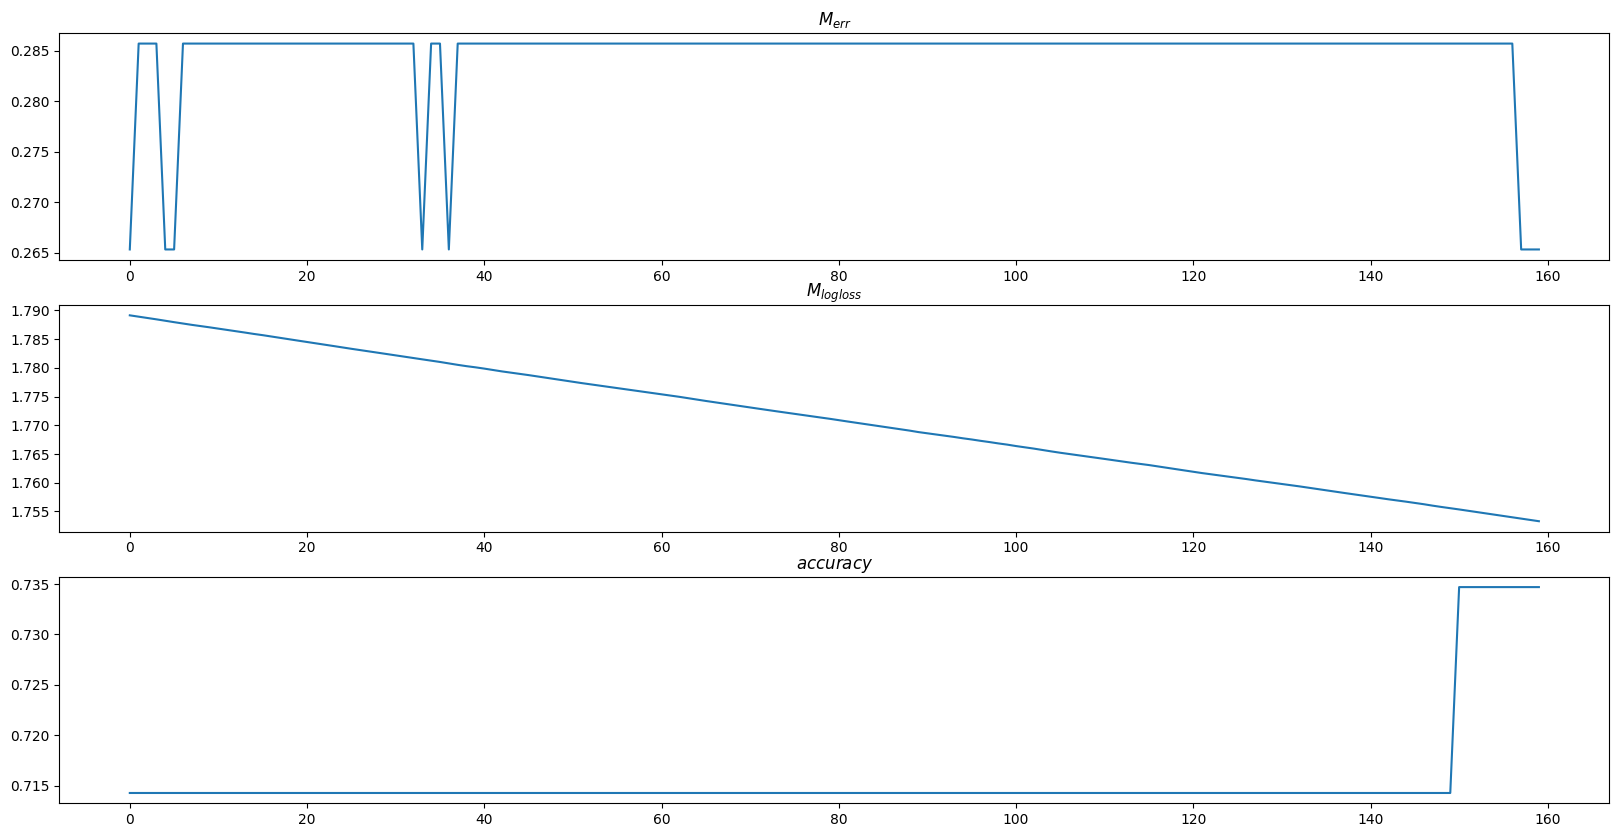

Best accuracy: 0.7346938775510204


In [ ]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt

b = best_trial.metrics['model'] if best_trial is not None else None
merrs = []
mloglosss = []
accs = []

# Train a few times the same model and save the error, log loss and accuracy
for _ in trange(16):
    b, acc, res = train_boost_genre({
        'params': best_trial.config['params'],
        "early_stopping_rounds": best_trial.config['early_stopping_rounds'],
        'model': b
    })
    merrs.extend(res['eval']['merror'])
    mloglosss.extend(res['eval']['mlogloss'])
    accs.extend([acc] * len(res['eval']['mlogloss']))

# Plot the 3 curves and find the best accuracy
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(3, 1, 1)
plt.plot(merrs)
plt.title('$M_{err}$')
fig.add_subplot(3, 1, 2)
plt.plot(mloglosss)
plt.title('$M_{logloss}$')
fig.add_subplot(3, 1, 3)
plt.plot(accs)
plt.title('$accuracy$')
plt.show()

print(f"Best accuracy: {max(accs)}")